# A/B testing
---
In this section, we do the A/B testing to investigate the effect of a new recommendation algorithm on user/group CTR. We are going to try a number of tests and metrics, try to increase the test sensitivity, and choose the most reliable approach. 

## Summary and Conclusion:
- At the level of group CTR, the new algorithm showed worse group CTR (21% vs 20% average).

- At the level of by-user CTR, the new algorithm caused users to split into two groups, with median CTR lower (approx 10%) and higher (30%) than in control group  (20%) having the old algorithm.
- If we are interested in only by-group CTR, the algorithm should **not** be used in the production.
- If we consider by-user CTR, we can use the algorithm in production if we are going to focus mostly on the users with increased CTR.

## Major Steps:

### 1. Splitting the Users into the Groups:
  - split the users into the groups by hashing with salt to allow random yet reproducible splitting
### 2. A/A Testing
  - check the equivalence of the groups metric before the test by t-testing pseudosamples from the groups and looking at p-value distribution

### 3. A/B Testing
  - do the testing, compare different techniques: t-test, Mann-Whitney U test. Smoothing of CTR, bootstrap, bucket testing

### 4. Conclusions
  - make a conclusion if the new system should be implemented.

### Table of Contents

- [Splitting the Users](#splitting-the-users): hashing with salt to do reproducible random splitting

- [A/A Testing](#aa-testing): t-testing pseudosamples from the groups, p-value distribution analysis
- [A/B Testing Comparison](#ab-testing-comparison): t-test, Mann-Whitney U test. Smoothing of CTR, bootstrap, bucket testing
- [Extra: A/B Testing of Linearized Likes](#ab-testing-of-linearized-likes): linearize the metric to increase the sensitivity.


### Imports, functions, global parameters

Imports

In [6]:
# to hide a database access password
import os
from dotenv import load_dotenv

# suppress pallette-related matplotlib warnings
import warnings 

from hashlib import md5 # do the splitting with this hash

# data work
import numpy as np
import pandas as pd
import swifter # applies any function to a pandas df or series faster

# database connection - modification of the original pandahouse package
import pandahouse_connector as ph

# stats work
import statsmodels.api as sm
import scipy.stats as stats

# plotting
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import seaborn as sns

Parameters, constants

In [7]:
# Load environment variables from .env file
load_dotenv(dotenv_path='../.env')

# introduce the secret variable to connect to the db
DA_SL_PWD = os.environ.get('DA_SL_PWD')

# set the connection with the db
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'database':'simulator_20230720',
    'user':'student', 
    'password':DA_SL_PWD
    }

# define the name of the schema
feed_db = 'simulator_20230720.feed_actions'

In [8]:
# suppress pallette-related matplotlib warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [9]:
# set the default figure quality and size
plt.rcParams['figure.dpi'] = 100 
plt.rcParams['figure.figsize'] = (9, 4)

Function and classes

In [10]:
# make a splitting function to make user groups
def ab_split(
    user_id,
    salt='exp_1', 
    n_groups=5
):
    # tag the id
    salted_id = str(user_id) + '-' + salt
    
    # hash the id with applied md5 function 
    # and convert the hashed id into an integer
    hashed_id = md5(salted_id.encode('ascii')).hexdigest()
    hashed_id = int(hashed_id, 16)
    
    # find modulo of the hash by no. group 
    # to assign a group
    return hashed_id % n_groups


In [11]:
# get a class that plots two histograms of the same plot 
# given an axis grid and font sizes

class HistPlotter:
    
    # initialize a class object with data and annotation parameters
    def __init__(
        self, 
        data,
        x,
        hue,
        xlabel=None,
        ylabel=None,
        title=None,
    ):
        self.data = data
        self.x = x
        self.hue = hue
        self.xlabel = xlabel
        self.ylabel = ylabel
        self.title = title

    # plot two histograms on the same plot given a grid axis
    def plot(
        self,
        ax=None,
        bins=100
    ):
        # make a canvas and axis if not provided as an input
        if not ax:
            fig, ax = plt.subplots()
            
        # adjust fonts and ticks
        ax.set_xlabel(self.xlabel)
        ax.set_ylabel(self.ylabel)
        ax.set_title(self.title)

        # create a histogram for each group
        sns.histplot(
            data=self.data,
            x=self.x,
                      hue=self.hue, 
                      palette=sns.color_palette('bright', as_cmap = True),
                      alpha=0.4,
                      kde=False,
                        ax=ax,
                        bins=bins
        )
        

In [12]:
# get a function that does Laplace smoothing
# for user CTR within each group
def get_smoothed_ctr(
    likes: pd.core.series.Series, 
    views: pd.core.series.Series, 
    global_ctr: float, 
    alpha: float=5
) -> pd.core.series.Series:
    
    smoothed_ctr = likes.add(alpha * global_ctr).div(views.add(alpha))
    return smoothed_ctr

In [13]:
# get a function to do bootstrap
def bootstrap(likes_control, views_control, likes_target, views_target, n_bootstrap=2000):
    """
    1. The function first calculates large number (N = n_bootstrap) of arrays with weights where every 
    element of an array represents a number of occurences (weight) of a particular element 
    of the sample to be bootstrapped. 
    Every array of weights would thus represent a "blueprint" of a pseudosample.
    2. Next, it calculates "global_CTR" for a pseudosample by calculating likes in the pseudosample
    (sum of (likes of user X) * (weight of user X in the pseudosample))
    and divides it by views in the pseudosample (same procedure as for likes).
    3. Step 2 is repeated for each pseudosample for each group (control and target). 
    It finally returns two arrays: global_CTR values for the control and target groups.    
    """

    # get the weights
    weights_control = stats.poisson(1).rvs(
        (n_bootstrap, 
         len(likes_control)
        )
    ).astype(np.int64)

    weights_target = stats.poisson(1).rvs(
        (n_bootstrap, 
         len(likes_target)
        )
    ).astype(np.int64)
    
    # get the global ctr for every pseudosample
    global_CTR_control = (weights_control * likes_control).sum(axis=1) / (weights_control * views_control).sum(axis=1)
    
    global_CTR_target = (weights_target * likes_target).sum(axis=1) / (weights_target * views_target).sum(axis=1)

    return global_CTR_control, global_CTR_target


<a id="splitting-the-users"></a>

### Splitting the users
---
Prior to the test, we need to split users into the testing groups.  

To achieve random yet determined and reproducible splitting, let's use hashing with the salt.  
For each user id, concatenate its string with a tag ('salt'), apply hash function to the resulting object and split into the groups.

In [14]:
# get a table with active users
# during the period from 23 June to 29 June
query = '''
SELECT DISTINCT toString(user_id) AS user_id
FROM {db}.feed_actions
WHERE (time BETWEEN '2023-06-23'::DATE AND'2023-06-29'::DATE)
'''

# import a table to a dataframe
users_to_hash = ph.read_clickhouse(
    query, 
    connection=CONNECTION
)


In [15]:
users_to_hash.info()
users_to_hash.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39140 entries, 0 to 39139
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  39140 non-null  object
dtypes: object(1)
memory usage: 305.9+ KB


,user_id
0,11509
1,14946


Now, classify the users into 5 groups - experimental and control groups

In [16]:
users_to_hash['exp_group'] = users_to_hash.user_id.swifter.apply(ab_split)
users_to_hash.head()

Pandas Apply: 100%|██████████| 39140/39140 [00:00<00:00, 296212.40it/s]


,user_id,exp_group
0,11509,2
1,14946,2
2,107626,3
3,117693,3
4,119016,3


Let's see group sizes - are they equal?

In [17]:
grouped_counts = users_to_hash.groupby('exp_group').count()
grouped_percentage = grouped_counts.div(grouped_counts.sum()).mul(100)

grouped_percentage

,user_id
exp_group,
0,20.005110
1,19.624425
2,20.434338
3,20.329586
4,19.606541


The groups seem to be euqal in sizes. Let's proceed further with the A/A testing.

<a id="aa-testing"></a>

### A/A testing
---
Before the A/B testing on groups 1 and 2, we need to do the A/A test on these groups to control that their CTR is statiscally euqivalent.  
For this, we will repeatedly take subsamples from each group, conduct paired t-tests, and then see how frequently the resulting p-value gets below significance level on 0.05 (how often we were to reject the null hypothesis).

We will simulate 10 000 A/A tests. In each iteration, we form subsamples without replacement of 500 users from both the 1nd and 2nd experimental groups. Then, we conduct a t-test to compare these subsamples.

1. Build a histogram representing the distribution of the resulting 10000 p-values.

2. Calculate the frequency of getting p-values less than or equal to 0.05.



#### 1. Groups overview

Let's see at how user CTR is distributed between the groups.

In [18]:
# get a table with users from groups 1 and 2 and their ctr
# during the period from 23 June to 29 June
query = '''
SELECT user_id,
exp_group,
likes,
views,
likes::FLOAT / views AS ctr
FROM (
SELECT user_id, 
exp_group,
countIf(action = 'like') AS likes,
countIf(action = 'view') AS views
FROM simulator_20230720.feed_actions
WHERE (time BETWEEN '2023-06-23'::DATE AND'2023-06-29'::DATE) 
AND exp_group IN (1, 2)
GROUP BY user_id, exp_group 
) aggregated_likes
'''

# import a table to a dataframe
user_ctr_aa_1_2 = ph.read_clickhouse(
    query, 
    connection=CONNECTION
)


In [19]:
# see the basic details of the df
user_ctr_aa_1_2.describe()

,user_id,exp_group,likes,views,ctr
count,15750.000000,15750.000,15750.000000,15750.000000,15750.000000
mean,70890.997968,1.496,13.511429,63.960825,0.220200
std,53241.223939,0.500,9.371593,42.814770,0.086453
min,206.000000,1.000,0.000000,1.000000,0.000000
25%,16032.500000,1.000,7.000000,31.000000,0.165354
50%,108437.500000,1.000,12.000000,54.000000,0.206897
75%,121511.750000,2.000,18.000000,87.000000,0.263158
max,133173.000000,2.000,89.000000,328.000000,0.857143


In [20]:
user_ctr_aa_1_2.head()

,user_id,exp_group,likes,views,ctr
0,109963,1,10,34,0.294118
1,18392,1,13,56,0.232143
2,131473,2,9,41,0.219512
3,23985,2,6,17,0.352941
4,24523,2,2,10,0.200000


In [21]:
# Let`s see how many users we have within each group
# - are the sizes equal?
user_ctr_aa_1_2.groupby('exp_group').user_id.count()

exp_group
1    7938
2    7812
Name: user_id, dtype: int64

Sizes are euqal. Let's go ahead and compare user CTRs distrubution between the groups.

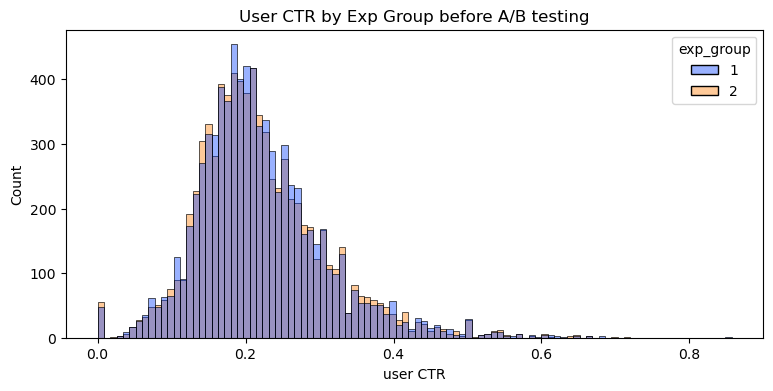

In [22]:
# make a canvas, set sizes

user_ctr_aa = HistPlotter(
    data=user_ctr_aa_1_2,
    x='ctr', 
    hue='exp_group',  
    xlabel='user CTR',
    ylabel='Count',
    title='User CTR by Exp Group before A/B testing'
)

user_ctr_aa.plot()


CTRs within two groups have equal distribution and seem to be almost equivalent, what if we go for a statistical test?

#### 2. Subsampling and paired t-test

Let's take subsamples from the groups many times and compare them by t-test. How often would the resulting p-values lie below confidence level?

In [23]:
# make separate dataframes for each group
# to make sampling for AA test easier
control_group = user_ctr_aa_1_2.loc[user_ctr_aa_1_2.exp_group == 1]
target_group = user_ctr_aa_1_2.loc[user_ctr_aa_1_2.exp_group == 2]

control_group.describe()


,user_id,exp_group,likes,views,ctr
count,7938.000000,7938.0,7938.000000,7938.000000,7938.000000
mean,71417.034895,1.0,13.510834,64.073948,0.220003
std,53177.159191,0.0,9.289267,42.801963,0.086076
min,206.000000,1.0,0.000000,4.000000,0.000000
25%,16161.750000,1.0,7.000000,32.000000,0.166667
50%,108649.500000,1.0,12.000000,55.000000,0.206897
75%,121667.250000,1.0,18.000000,87.000000,0.262295
max,132176.000000,1.0,89.000000,304.000000,0.857143


In [24]:
# now to the AA test:

# create a list to append p-values to 
pvalues = []

# set values for a number of iterations and sample size
iterations = 10000
sample_size = 500

# perform AA test multiple times:
# take subsamples from our groups
# and compare them by paired t-test
for _ in range(iterations):
    control_sample = control_group.ctr.sample(sample_size, replace=False).tolist()
    target_sample = target_group.ctr.sample(sample_size, replace=False).tolist()
    
    results = sm.stats.ttest_ind(
        control_sample,
        target_sample,
        usevar='unequal'
    )
    
    # take p-value from a test to a separate array
    pvalues.append(results[1])
    
pvalues_aa_1_2 = pd.DataFrame({'p_value': pvalues})


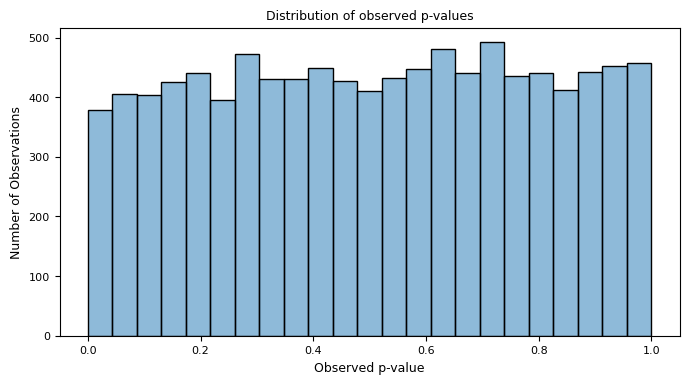

In [25]:
# make a canvas, set sizes
fig, ax = plt.subplots(figsize=(8, 4))

fontsize=9
labelsize=8

# create a bar plot
sns.histplot(pvalues_aa_1_2, legend=False)

# adjust fonts and ticks
ax.set_xlabel('Observed p-value', fontsize=fontsize)
ax.set_ylabel('Number of Observations', fontsize=fontsize)
ax.set_title('Distribution of observed p-values', fontsize=fontsize)

ax.tick_params(axis='y', labelsize=labelsize)
ax.tick_params(axis='x', labelsize=labelsize)

plt.show()


p-values seem to be distributed uniformly, which indicates equivalence of groups compared.  
How often did the p-value end up below 0.05 (level at which we would reject H<sub>0</sub>')?

In [26]:
# set the level
significance_level = 0.05

# count tests where p-value was below the level
condition = pvalues_aa_1_2.p_value <= significance_level
error_rate = pvalues_aa_1_2.loc[condition].count() / pvalues_aa_1_2.count()

error_rate.sum()

0.0448

#### 3. Summary:
The groups are equivalent (similar in size and user CTR behaviour).
As we carry out multiple AA-tests between the samples from the two groups, we get p-values below 0.05 at a 0.0431 frequency, which is a good indicator that the groups are similar.

<a id="ab-testing-comparison"></a>

### A/B testing comparison
---

Now, we need to analyze the effect of the new recommendation algorithm.

Test: new algorithm (group 2) VS old one (group 1) from 2023-06-30 to 2023-07-06.  
Hypothesis: new system leads to increase in CTR.

Methods to use and compare:
  - User CTR: Paired t-test and Mann-Whitney U test
  
  - smoothed user CTR: Paired t-test and Mann-Whitney U test
  - bucket CTR after bucket transformation: Paired t-test and Mann-Whitney U test
  - bootstraped group CTR: Paired t-test

---
#### 1. Groups overview after A/B testing
Now to the A/B testing: get user CTR for users in group 1 (control) and 2 (target) over the period from 2023-06-30 to 2023-07-06

In [27]:
# get a table with users from groups 1 and 2 and their ctr
# during the period from 30 June to 6 July

query = '''
SELECT user_id,
if(exp_group = 1, 'control', 'target') AS exp_group,
likes,
views,
likes::FLOAT / views AS ctr
FROM (
SELECT user_id, 
exp_group,
countIf(action = 'like') AS likes,
countIf(action = 'view') AS views
FROM simulator_20230720.feed_actions
WHERE (time BETWEEN '2023-06-30'::DATE AND '2023-07-07'::DATE) 
AND exp_group IN (1, 2)
GROUP BY user_id, exp_group 
) aggregated_likes
'''

# import a table to a dataframe
user_ctr_ab_1_2 = ph.read_clickhouse(
    query, 
    connection=CONNECTION
)


In [28]:
# see the basic details of the df
user_ctr_ab_1_2.describe()

,user_id,likes,views,ctr
count,19898.000000,19898.000000,19898.000000,19898.000000
mean,75510.971957,13.689567,66.790682,0.216429
std,53254.468009,10.879848,45.365962,0.116621
min,206.000000,0.000000,1.000000,0.000000
25%,21945.500000,6.000000,32.000000,0.119403
50%,109318.000000,11.000000,57.000000,0.200000
75%,126144.250000,19.000000,91.000000,0.291667
max,140740.000000,93.000000,341.000000,0.900000


In [29]:
user_ctr_ab_1_2.head()

,user_id,exp_group,likes,views,ctr
0,109963,control,3,15,0.200000
1,26117,control,32,141,0.226950
2,138232,control,18,73,0.246575
3,18392,control,7,32,0.218750
4,26295,control,39,141,0.276596


In [30]:
# Let`s see how many users we have within each group
# - are the sizes equal?
user_ctr_ab_1_2.groupby('exp_group').user_id.count()

exp_group
control    10020
target      9878
Name: user_id, dtype: int64

Sizes are similar. Let's go ahead and compare user CTRs distrubution between the groups.

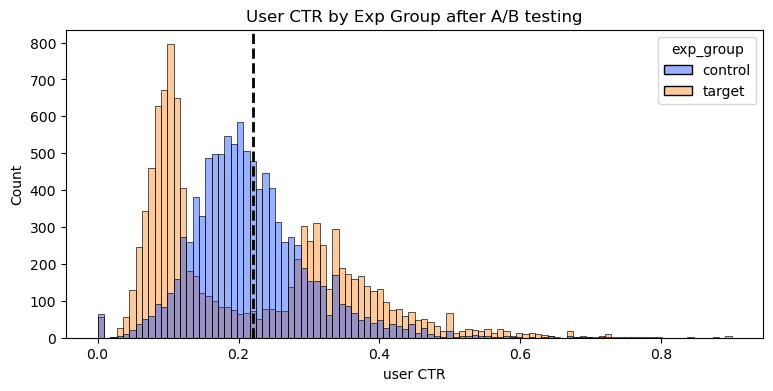

In [31]:
hist_user_ctr_ab = HistPlotter(
    data=user_ctr_ab_1_2,
    x='ctr', 
    hue='exp_group',  
    xlabel='user CTR',
    ylabel='Count',
    title='User CTR by Exp Group after A/B testing'
)

hist_user_ctr_ab.plot()
plt.axvline(x=0.22, linewidth=2, color='black', linestyle='--')
plt.show()

In [32]:
user_ctr_ab_1_2.groupby('exp_group').median()

,user_id,likes,views,ctr
exp_group,,,,
control,109387.0,12.0,57.0,0.205882
target,109215.5,10.0,57.0,0.153255


- The behaviour of the group 1 (control) stayed visually the same as it was before the test.  

- However, the group 2 (target) started to behave differently: the distribution became bimodal - some users got weaker conversion, while the rest increased their CTR.  

Let's try to have a look if there is any difference in users with different behaviour in the target? Age, gender, OS type? Their general acitivty (views)? Their source (ad/organic)?  
The black line at CTR=0.22 shows separarion of the two subgroups in the target.

In [33]:
# Let's first see what is the contribution of each subgroup (low-high CTR)
# to the total target group
target_ctr = user_ctr_ab_1_2.loc[user_ctr_ab_1_2.exp_group == 'target', ['ctr']]
target_ctr['ctr_group'] = np.where(target_ctr.ctr <= 0.22,'low', 'high')

target_ctr.groupby('ctr_group').count().div(target_ctr.ctr.count()).mul(100).rename(columns={'ctr':'percentage'})

,percentage
ctr_group,
high,43.885402
low,56.114598


As we can see, in the target group we have more users having lower CTR (first peak) than those with higher CTR.

To make user groups based on their activity (to see how they are represented in each subgroup), let's plot the by user views distribution.

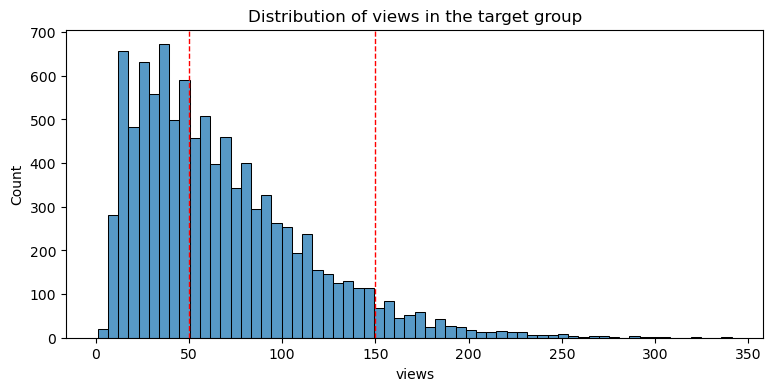

In [34]:
# fig, ax = plt.subplots(figsize=(9, 4))

sns.histplot(user_ctr_ab_1_2.loc[user_ctr_ab_1_2.exp_group == 'target'], x='views')
plt.title('Distribution of views in the target group')
plt.axvline(x=50, linewidth=1, color='red', linestyle='--')
plt.axvline(x=150, linewidth=1, color='red', linestyle='--')
plt.show()

We will split the target users into 3 groups based on their views: low activity (< 50), high activity (> 150), and medium activity.  
For their age, we split into 0-16, 17-55, and 55+.  
As for the country, look at German and non-German users as it gives the highest contribution in the user influx.

In [83]:
# get a table with users from groups 1 and 2 and their ctr and age group, 
# sex, os_type, or their source
# during the period from 30 June to 6 July

query = '''
SELECT user_id,
if(exp_group = 1, 'control', 'target') AS exp_group,
os,
gender,
age_group,
country,
source,
likes,
views,
multiIf(views <= 50, '0-50', views > 150, '150+', '51-150') AS views_group,
likes::FLOAT / views AS ctr
FROM (
SELECT user_id, 
exp_group,
os,
gender,
source,
multiIf(age <= 16, '0-16', age > 55, '55+', '17-55') AS age_group,
country,
countIf(action = 'like') AS likes,
countIf(action = 'view') AS views
FROM simulator_20230720.feed_actions
WHERE (time BETWEEN '2023-06-30'::DATE AND '2023-07-07'::DATE) 
AND exp_group IN (1, 2)
GROUP BY user_id, exp_group, os, gender, age_group, source, country
) aggregated_likes
'''

# import a table to a dataframe
user_ctr_ab_complete = ph.read_clickhouse(
    query, 
    connection=CONNECTION
)


In [90]:
# make an extra column showing if a user is from Germany
user_ctr_ab_complete['country_is_germany'] = user_ctr_ab_complete.loc[:, 'country'] == 'Germany'

In [88]:
user_ctr_ab_complete.head()

,user_id,exp_group,os,gender,age_group,country,source,likes,views,views_group,ctr,is_germany
0,129946,control,Android,1,17-55,Germany,organic,33,109,51-150,0.302752,True
1,7047,target,Android,0,17-55,Germany,ads,1,15,0-50,0.066667,True
2,22591,control,iOS,0,17-55,Cyprus,ads,10,64,51-150,0.156250,False
3,22920,control,Android,0,17-55,Azerbaijan,ads,7,25,0-50,0.280000,False
4,23775,target,Android,1,17-55,Germany,ads,8,97,51-150,0.082474,True


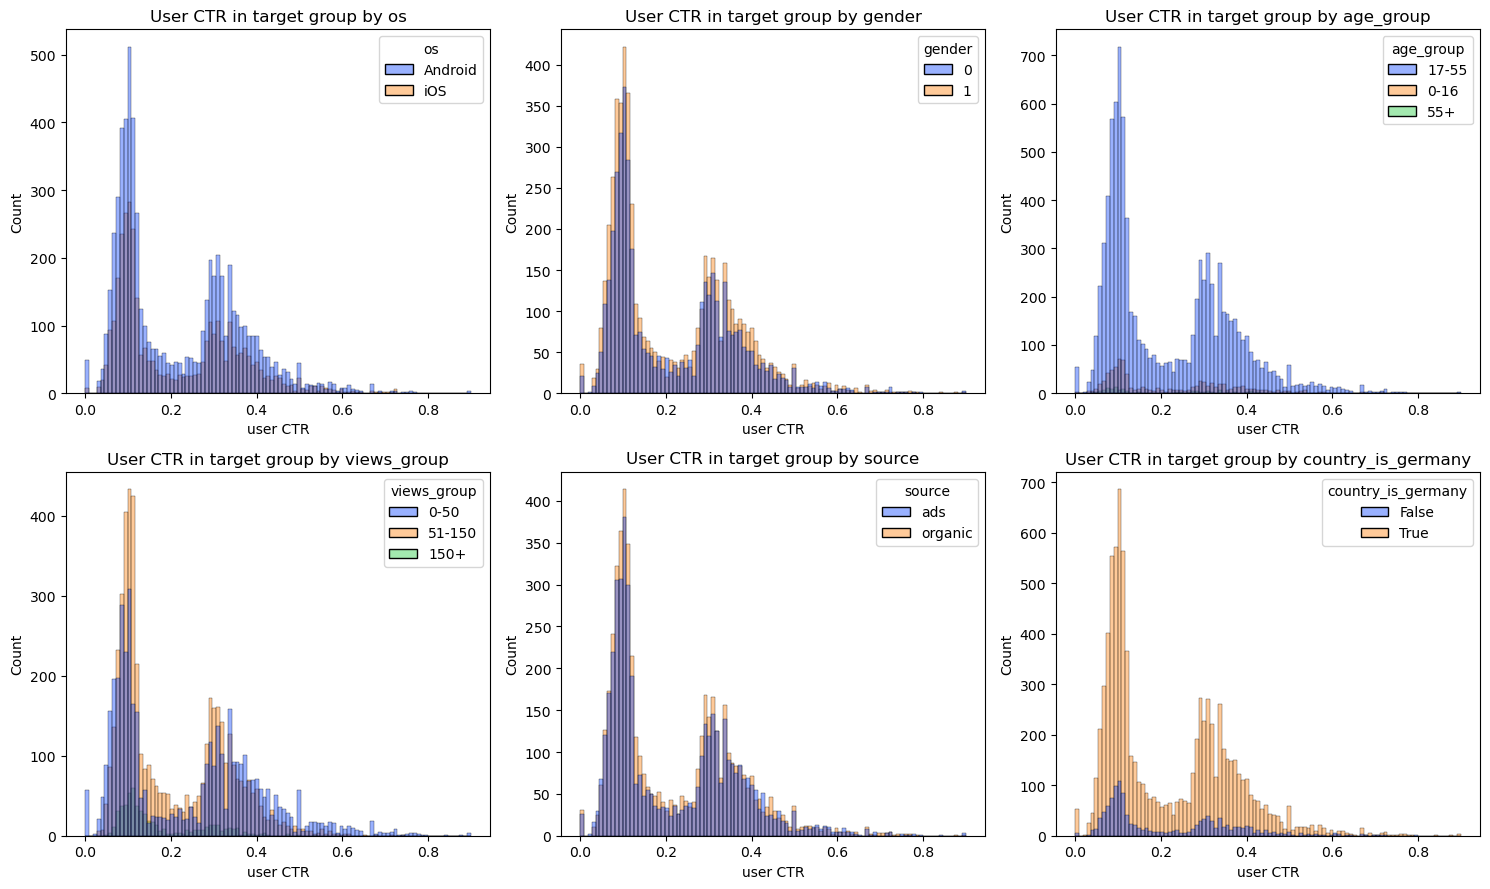

In [91]:
# make a canvas, set sizes
fig, axs = plt.subplots(2, 3, figsize=(15, 9))

hues = ['os', 
        'gender', 
        'age_group', 
        'views_group', 
        'source', 
        'country_is_germany'
       ]

for hue, ax in zip(hues, axs.reshape(-1)):
    plotter_obj = HistPlotter(
        data=user_ctr_ab_complete.loc[user_ctr_ab_complete.exp_group == 'target'],
        x='ctr', 
        hue=hue,  
        xlabel='user CTR',
        ylabel='Count',
        title=f'User CTR in target group by {hue}'
    )
    
    plotter_obj.plot(ax=ax)
plt.tight_layout()

- All of the subgroups behave similarly here, except for the splitting by views: there is a slight trend that as activity goes low, there is more separation into the two modes, whilist at higher activity, the distribution tends towards more unimodality.  

- Either the difference lies in the other feature of the group we are not aware of, or the new system was somehow differently introduced within the group.  

Anyway, proceed with what we have and put it to the test.

#### 2. Paired t-test and Mann-Whitney U test for user CTR
Try to apply the t-test to the groups:

In [38]:
# create for the groups
control_sample = user_ctr_ab_1_2.loc[user_ctr_ab_1_2.exp_group == 'control']
target_sample = user_ctr_ab_1_2.loc[user_ctr_ab_1_2.exp_group == 'target']

In [39]:
# perform A/B test analysis by paired t-test    
results = sm.stats.ttest_ind(
        control_sample.ctr,
        target_sample.ctr,
        usevar='unequal'
    )
    
output_ttest_user = pd.DataFrame(
    {key: value for key, value in zip(['statistic', 'pvalue', 'degrees of freedom'], results)},
    index=[0]
).pvalue

output_ttest_user

0    0.676155
Name: pvalue, dtype: float64

Based on this t-test result, we can not decline H0 at 95% confidence level.  
Now try Mann-Whitney U test

In [40]:
results = stats.mannwhitneyu(
    control_sample.ctr,
    target_sample.ctr,
    alternative = 'two-sided')

output_mannwhitneyu_user = pd.DataFrame(
    {key: value for key, value in zip(['statistic', 'pvalue', 'degrees of freedom'], results)},
    index=[0]
)['pvalue'] 

output_mannwhitneyu_user

0    3.971156e-45
Name: pvalue, dtype: float64

Opposite result: we should decline H0 and say that the samples are different.


---
#### 3. Tests on smoothed user CTR

Try to do smoothing for user CTR and test this metric. It can increase the sensitivity, but does not guarantee to have the same direction of changes as original raw metric.

In [41]:
# create aliases
control_sample = user_ctr_ab_1_2.loc[user_ctr_ab_1_2.exp_group == 'control']
control_global_ctr = control_sample.likes.sum() / control_sample.views.sum()

target_sample = user_ctr_ab_1_2.loc[user_ctr_ab_1_2.exp_group == 'target']
target_global_ctr = target_sample.likes.sum() / target_sample.views.sum()


In [42]:
# smooth the ctr
user_ctr_ab_1_2.loc[user_ctr_ab_1_2.exp_group == 'control', 'ctr_smoothed'] = get_smoothed_ctr(control_sample.likes, control_sample.views, control_global_ctr)
user_ctr_ab_1_2.loc[user_ctr_ab_1_2.exp_group == 'target', 'ctr_smoothed'] = get_smoothed_ctr(target_sample.likes, target_sample.views, target_global_ctr)

user_ctr_ab_1_2.head()

,user_id,exp_group,likes,views,ctr,ctr_smoothed
0,109963,control,3,15,0.200000,0.202401
1,26117,control,32,141,0.226950,0.226356
2,138232,control,18,73,0.246575,0.244205
3,18392,control,7,32,0.218750,0.217514
4,26295,control,39,141,0.276596,0.274301


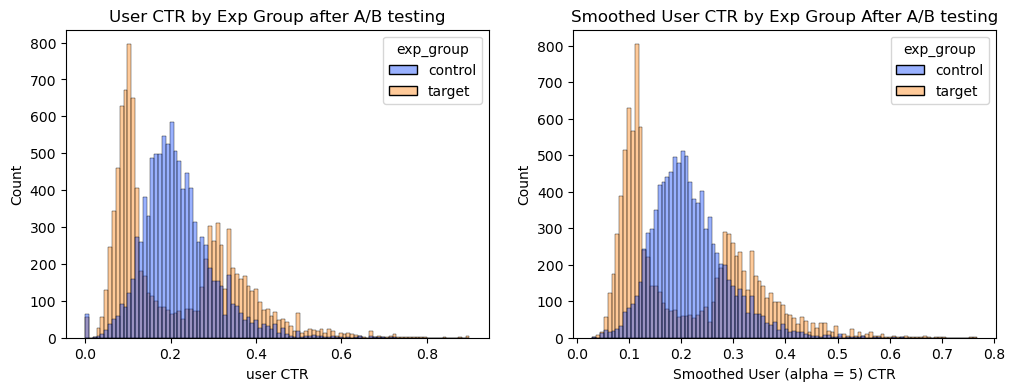

In [43]:
# make a canvas, set sizes
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# plot histograms to compare user CTRs
# between the groups after the experiment
hist_user_ctr_ab.plot(ax=axs[0])

# plot histograms to compare smoothed user CTRs
# between the groups after the experiment
hist_user_ctr_smoothed_ab = HistPlotter(
    data=user_ctr_ab_1_2,
    x='ctr_smoothed', 
    hue='exp_group',  
    xlabel='Smoothed User (alpha = 5) CTR',
    ylabel='Count',
    title='Smoothed User CTR by Exp Group After A/B testing'
)
hist_user_ctr_smoothed_ab.plot(ax=axs[1])


Smoothing worked! For instance, we got less outliers with extreme values of the metric. Compare it by tests now.

In [44]:
# create aliases
control_sample = user_ctr_ab_1_2.loc[user_ctr_ab_1_2.exp_group == 'control']
target_sample = user_ctr_ab_1_2.loc[user_ctr_ab_1_2.exp_group == 'target']

In [45]:
# perform A/B test analysis by paired t-test
results = sm.stats.ttest_ind(
        control_sample.ctr_smoothed,
        target_sample.ctr_smoothed,
        usevar='unequal'
    )
    
output_ttest_user_smooth = pd.DataFrame(
    {key: value for key, value in zip(['statistic', 'pvalue', 'degrees of freedom'], results)},
    index=[0]
)['pvalue']
output_ttest_user_smooth

0    0.051346
Name: pvalue, dtype: float64

After the smoothing, p-value dropped from approx 0.6 to 0.05 due to the noise smoothing. However, we still can not decline H0 now.

In [46]:
results = stats.mannwhitneyu(
    control_sample.ctr_smoothed,
    target_sample.ctr_smoothed,
    alternative = 'two-sided')

output_mannwhitneyu_user_smooth = pd.DataFrame(
    {key: value for key, value in zip(['statistic', 'pvalue'], results)},
    index=[0]
)['pvalue']
output_mannwhitneyu_user_smooth

0    2.224838e-50
Name: pvalue, dtype: float64

Opposite from t-test result: we should decline H0 and say that the samples are different.


---
#### 4. Paired t-test and Mann-Whitney U test for CTR in buckets.

Now to the bucket transformation: for each group, split the users randomly (hash approach) into 50 buckets and for each bucket, calculate the aggregated CTR.

In [47]:
# get a table with users from groups 1 and 2 and their ctr
# during the period from 30 June to 7 July

query = '''
SELECT if(exp_group = 1, 'control', 'target') AS exp_group, 
        bucket,
    sum(likes)/sum(views) as bucket_ctr
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2023-06-30'::DATE AND '2023-07-07'::DATE
        and exp_group in (1, 2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
'''

# import a table to a dataframe
user_ctr_ab_1_2_bucket = ph.read_clickhouse(
    query, 
    connection=CONNECTION
)


In [48]:
user_ctr_ab_1_2_bucket.head()

,exp_group,bucket,bucket_ctr
0,control,41,0.203255
1,control,40,0.208539
2,target,34,0.195876
3,target,35,0.203334
4,target,15,0.218051


In [49]:
user_ctr_ab_1_2_bucket.groupby('exp_group').count()

,bucket,bucket_ctr
exp_group,,
control,50,50
target,50,50


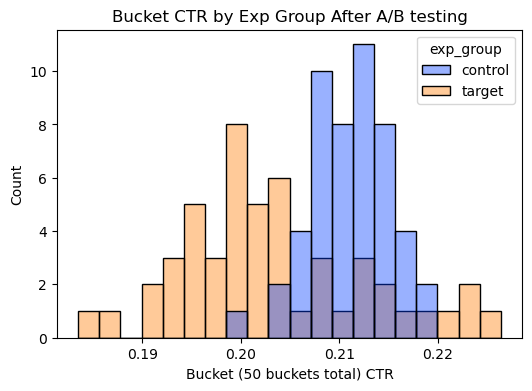

In [50]:
# make a canvas, set sizes
fig, ax = plt.subplots(figsize=(6, 4))

# plot histograms to compare backet CTRs
# between the groups after the experiment
hist_bucket_ctr_ab = HistPlotter(
    data=user_ctr_ab_1_2_bucket,
    x='bucket_ctr', 
    hue='exp_group',  
    xlabel='Bucket (50 buckets total) CTR',
    ylabel='Count',
    title='Bucket CTR by Exp Group After A/B testing',
)
hist_bucket_ctr_ab.plot(ax=ax, bins=20)

This metric seems to have dropped in the target group. Go for the tests!

In [51]:
# create aliases
control_sample = user_ctr_ab_1_2_bucket.loc[user_ctr_ab_1_2_bucket.exp_group == 'control']
target_sample = user_ctr_ab_1_2_bucket.loc[user_ctr_ab_1_2_bucket.exp_group == 'target']

In [52]:
# perform A/B test analysis by paired t-test
results = sm.stats.ttest_ind(
        control_sample.bucket_ctr,
        target_sample.bucket_ctr,
        usevar='unequal'
    )
    
output_ttest_bucket = pd.DataFrame(
    {key: value for key, value in zip(['statistic', 'pvalue', 'degrees of freedom'], results)},
    index=[0]
).pvalue
output_ttest_bucket

0    0.000001
Name: pvalue, dtype: float64

In [53]:
results = stats.mannwhitneyu(
    control_sample.bucket_ctr,
    target_sample.bucket_ctr,
    alternative = 'two-sided')

output_mannwhitneyu_bucket = pd.DataFrame(
    {key: value for key, value in zip(['statistic', 'pvalue'], results)},
    index=[0]
).pvalue
output_mannwhitneyu_bucket

0    7.563124e-07
Name: pvalue, dtype: float64

According to both results, we should decline H0 and conclude the metric has indeed dropped in the target.

---
#### 5. Poisson bootstrap.
Apart from user CTR and bucket metric, we can also try to look at the group CTR and compare them for control and target. However, we have only one observation per group for this metric.  
The way to solve this problem is via bootstrap where, if we think our group nicely represent the population, we can 'imitate' how the group metric would be distributed upon multiple sampling (i.e. multiple A/B testing).  


At this step, we need to generate many pseudosamples with replacement from the sample with likes and views of groups 1 and 2. Sizes of the pseudosamples will be equal to the initial sample size.  
To enhance rate of sampling, we will *instead of direct sampling* of values calculate *how many times* each value of the initial sample *appeared* in the pseudosample.  
As we assume out samples to be large enough, we can generate occurence rate of every element by using Poisson distrubition with lambda = 1, which kind of reflects the Poisson limit theorem: occurence rate of an element from a sample size N in a pseudosample size N, which is described by Binomial(N, 1/N), can be approximated by Poisson(1) once N is large enough.  
Once we know occurence rate for every sample element, we can build a pseudosample. Repeating this many times (e.g., 2000) would give us many pseudosamples, for each of them we can find group CTR (total likes / total views).   
This will give us an estimate of how variable CTR in population is. Having this distributions in hand, we can compare their means by the appropriate methods.

In [54]:
# create aliases
control_sample = user_ctr_ab_1_2.loc[user_ctr_ab_1_2.exp_group == 'control']
target_sample = user_ctr_ab_1_2.loc[user_ctr_ab_1_2.exp_group == 'target']

In [55]:
# make numpy arrays out ouf the series to use them in our function
likes_control = control_sample.likes.to_numpy()
views_control = control_sample.views.to_numpy()

likes_target = target_sample.likes.to_numpy()
views_target = target_sample.views.to_numpy()

bootstrap_output = bootstrap(likes_control, views_control, likes_target, views_target)


In [56]:
# make a df with each row having array of bootstraped group CTR
bootstrap_df = pd.DataFrame(
    {'exp_group': ['control', 'target'],
     'group_ctr': [*bootstrap_output]
    }
)
bootstrap_df.head()


,exp_group,group_ctr
0,control,"[0.20834322326879445, 0.20849435146660425, 0.2..."
1,target,"[0.19824071794029932, 0.19953506392870982, 0.1..."


In [57]:
# explode the arrays in column 'group_ctr' into the rows
# ignore_index makes resulting index from 0 to n-1
# instead of 0, 0, ..., 0, 1, 1, ..., 1
bootstrap_df_exploded = bootstrap_df.explode('group_ctr', ignore_index=True)
bootstrap_df_exploded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   exp_group  4000 non-null   object
 1   group_ctr  4000 non-null   object
dtypes: object(2)
memory usage: 62.6+ KB


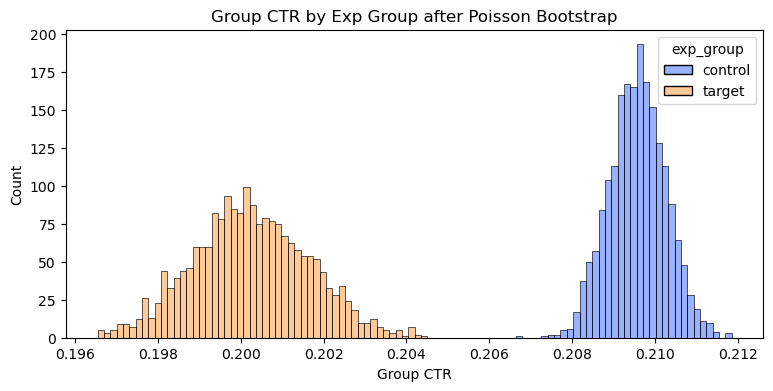

In [58]:
# plot histograms to compare group CTRs
# between the groups after the experiment and bootstrapping
hist_bootstrap_ctr_ab = HistPlotter(
    data = bootstrap_df_exploded, 
    x='group_ctr',
    hue='exp_group',
    xlabel='Group CTR',
    ylabel='Count',
    title='Group CTR by Exp Group after Poisson Bootstrap'
)
hist_bootstrap_ctr_ab.plot()


In [59]:
bootstrap_df_exploded.groupby('exp_group').median()

,group_ctr
exp_group,
control,0.209576
target,0.200184


- Instead of having bimodal distribution, as we saw for user CTR, group CTR for target gives us unimodal distribution. This can be due to the averaging of the CTR by counting all likes and dividing them by all views in the pseudosample.  

- According to the boostrapped distributions (visual comparison), CTR dropped in the target group. The distributions do not overlap and if we apply paired t-test to them, we will likely get zero p-value.

In [60]:
# make aliases
control_sample = bootstrap_df_exploded[bootstrap_df_exploded.exp_group == 'control']
target_sample = bootstrap_df_exploded[bootstrap_df_exploded.exp_group == 'target']

# perform A/B test analysis by paired t-test for bootstrapped distributions
results = sm.stats.ttest_ind(
        control_sample.group_ctr,
        target_sample.group_ctr,
        usevar='unequal'
    )
    
output_ttest_bootstrap = pd.DataFrame(
    {key: value for key, value in zip(['statistic', 'pvalue', 'degrees of freedom'], results)},
    index=[0]
).pvalue
output_ttest_bootstrap

0    0.0
Name: pvalue, dtype: float64

p-value equals zero, and we should decline H0 and consider distributions different.

---
#### 6. Summary

Let's aggregate the results of the tests we carried out and the histograms we plotted.

In [61]:
# make a df with the p-values
pvalues = [output_ttest_user,
output_mannwhitneyu_user,
output_ttest_user_smooth,
output_mannwhitneyu_user_smooth,
output_ttest_bucket,
output_mannwhitneyu_bucket,
output_ttest_bootstrap
          ]

names = ['User t-test',
         "User Mann-Whitney's U test",
         'User smooth t-test',
         "User smooth Mann-Whitney's U test",
         'Bucket t-test',
         "Bucket Mann-Whitney's U test",
         'Bootstrap (group) ttest'
        ]

pvalues_annotated = pd.merge(pd.concat(pvalues, ignore_index=True), pd.DataFrame({'type': names}), left_index=True, right_index=True)
pvalues_annotated['decline H0'] = pvalues_annotated.pvalue <= 0.05


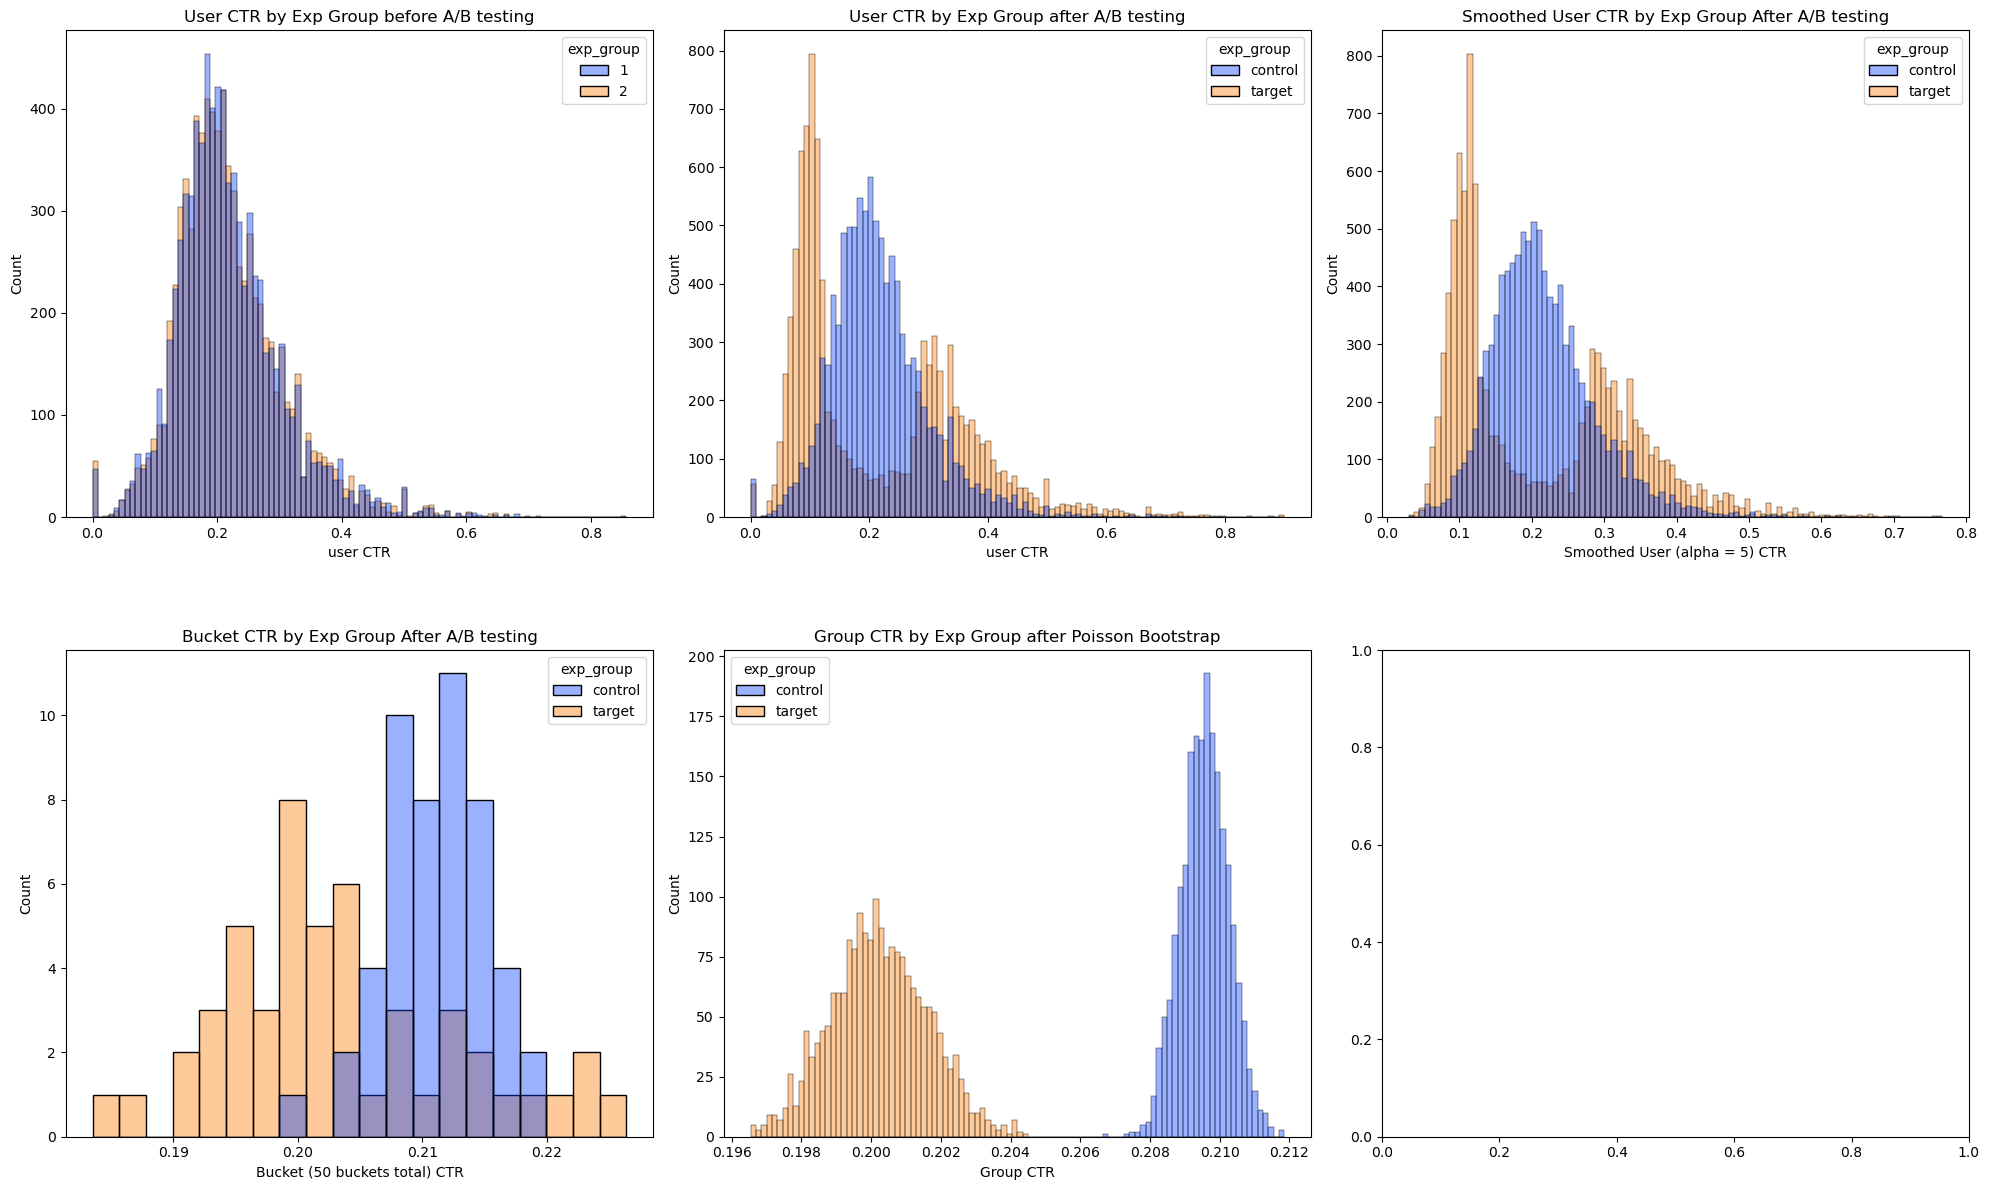

In [62]:
# plot together the histograms we had
# make a canvas, set sizes
fig, axs = plt.subplots(2, 3, figsize=(20, 12))

to_plot = [user_ctr_aa,
            hist_user_ctr_ab,
            hist_user_ctr_smoothed_ab,
            hist_bucket_ctr_ab,
            hist_bootstrap_ctr_ab
          ]

for plot, ax in zip(to_plot, axs.reshape(-1)):
    if plot is hist_bucket_ctr_ab:
        plot.plot(ax=ax, bins=20)
        continue
    plot.plot(ax=ax)
    
plt.tight_layout(h_pad=5)

In [63]:
pvalues_annotated[['type', 'pvalue', 'decline H0']]

,type,pvalue,decline H0
0,User t-test,6.761553e-01,False
1,User Mann-Whitney's U test,3.971156e-45,True
2,User smooth t-test,5.134612e-02,False
3,User smooth Mann-Whitney's U test,2.224838e-50,True
4,Bucket t-test,1.161116e-06,True
5,Bucket Mann-Whitney's U test,7.563124e-07,True
6,Bootstrap (group) ttest,0.000000e+00,True


Comparison of the results:  
1. New feature applied to the target group (new recommendation algorithm) splitted the users into the two subgroups: one increased their user CTR compared to the control, while another subgroup descreased in metrics, so the two modes of the target user distribution ended up around the mode of the control metrics.

2. Partly because of that, paired t-test did not show the difference in the user CTR. Even reducing the noise by smoothing (which partly got rid of extreme values) did not lead to changing the verdict (although the p-value dropped dramatically).
3. Mann-Whitney U test, however, showed the difference in the user metrics both times. It can be that H0 (for randomly chosen x1 and x2 from groups 1 and 2 P(x1 < x2) = P(x1 > x2)) should be declined because two modes (two peaks) of the target group do not have euqal shape (peak 1 is narrow and high, while peak 2 is wide and low), even though they surround control peak at the same distance, which can introduce difference in the comparisons.
4. In the tests with bucketization, both tests showed difference in groups. It can be that when randomly splitting the users into the buckets, we get averaging of the metrics from both modes of the target group, so the resulting distribution of bucket CTR is unimodal and shifted towards lower CTR (due to larger contribution from the left mode) than control metrics.
5. Somewhat similar result was observed with bootstrapped group CTR. However, the difference between the groups is more dramatic here - the distributions do not overlap. This can be due to the iterative nature of bootstrap: when sampling a pseudosample from the target distribution, we on average get more observations from the first mode than the second mode, so each iteration may increase the bias and as we sample more and more, the distribution of group CTR would shift towards the left mode more. Indeed, there can be some trend of 'narrowing' the bootstrapped distribution with the increased sample number.

Why could CTR split into two distributions after new algorithm was applied?
1. For every parameter of the group we compared (os type, gender, age, view activity, ad/organic source, country), there is no difference in behaviour within the target group users - each subgroup showed bimodal distribution of user CTR, which was averaged by bucketing and bootstrap and made the mean lower than in control group. Two possible explanations here: there either can be another parameter of the users (e.g. subscribers/non-subscribers, dark/light theme, old/new app version) which is responsible for the two-sided changes in CTR or the new recommendation system was somehow non-uniformly applied to this group (some users received third type of the system in target group).

Do we agree to use the new system on all users?
1. Looking at the user CTR, we can see that there is a subgroup of the target group that gained higher CTR values. It is not a major subgroup (only approx 44% of target users had this behaviour), however, we can try running another AB test where this 44% users would have equal size as a control group so that we can compare them. If this is a significant difference, we could focus our attention on this group of the users.  

2. Looking at the group CTR (the one we initally wanted to compare), there is clearly a decrease in the metric for the target group. I would not recommend to upscale the system.

<a id="ab-testing-of-linearized-likes"></a>

### A/B testing of linearized likes
---
Finally, to increase the sensitivity of the test, we can apply linearization technique to likes metric.

The idea of the method:

Instead of testing "per-user" CTR, we can construct another metric and analyze it. However, unlike smoothed CTR, it is guaranteed that if the test on this other metric detects changes, it means there are changes in the original metric (i.e., in likes per user and in user CTR).

The method itself is very simple.

1. Calculate the overall CTR in the control group: 𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙 = 𝑠𝑢𝑚(𝑙𝑖𝑘𝑒𝑠) / 𝑠𝑢𝑚(𝑣𝑖𝑒𝑤𝑠).

2. Calculate the per-user metric in both groups: 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠 = 𝑙𝑖𝑘𝑒𝑠 - 𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙 * 𝑣𝑖𝑒𝑤𝑠.

3. Then compare the differences in groups using a t-test for the metric 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠.

Task:

1. Analyze the test between groups 0 and 3 using the metric of linearized likes. Is there any difference visible? Has 𝑝-value become smaller?

2. Analyze the test between groups 1 and 2 using the metric of linearized likes. Is there any difference visible? Has 𝑝-value become smaller?

#### 1. Paired t-test on user CTR

Let's perform paired t-test on linearized likes for groups 0-3 and 1-2.  
To do this, we first do t-test for CTR for groups 0-3 as we didn't do that before.

In [64]:
# get a table with users from groups 0 and 3 and their ctr
# during the period from 30 June to 6 July

query = '''
SELECT user_id,
if(exp_group = 0, 'control', 'target') AS exp_group,
likes,
views,
likes::FLOAT / views AS ctr
FROM (
SELECT user_id, 
exp_group,
countIf(action = 'like') AS likes,
countIf(action = 'view') AS views
FROM simulator_20230720.feed_actions
WHERE (time BETWEEN '2023-06-30'::DATE AND '2023-07-07'::DATE) 
AND exp_group IN (0, 3)
GROUP BY user_id, exp_group 
) aggregated_likes
'''

# import a table to a dataframe
user_ctr_ab_0_3 = ph.read_clickhouse(
    query, 
    connection=CONNECTION
)


In [65]:
user_ctr_ab_0_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19922 entries, 0 to 19921
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   user_id    19922 non-null  uint32 
 1   exp_group  19922 non-null  object 
 2   likes      19922 non-null  uint64 
 3   views      19922 non-null  uint64 
 4   ctr        19922 non-null  float64
dtypes: float64(1), object(1), uint32(1), uint64(2)
memory usage: 700.5+ KB


In [66]:
user_ctr_ab_0_3.head()

,user_id,exp_group,likes,views,ctr
0,115383,target,12,44,0.272727
1,123580,target,2,11,0.181818
2,4944,control,8,41,0.195122
3,4504,control,5,15,0.333333
4,121508,control,6,25,0.240000


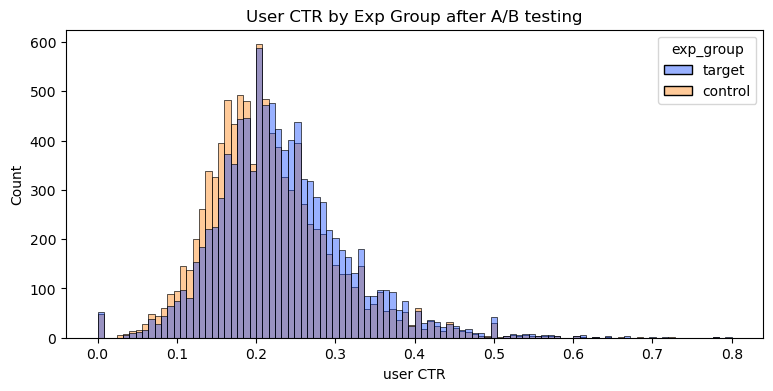

In [67]:
# make a canvas, set sizes

hist_user_ctr_ab_3_4 = HistPlotter(
    data=user_ctr_ab_0_3,
    x='ctr', 
    hue='exp_group',  
    xlabel='user CTR',
    ylabel='Count',
    title='User CTR by Exp Group after A/B testing'
)

hist_user_ctr_ab_3_4.plot()


There seems to be a shift of the user CTR in control group (towards lower CTR). Let's do the test.

In [68]:
# create for the groups
control_sample = user_ctr_ab_0_3.loc[user_ctr_ab_0_3.exp_group == 'control']
target_sample = user_ctr_ab_0_3.loc[user_ctr_ab_0_3.exp_group == 'target']

In [69]:
# perform A/B test analysis by paired t-test    
results = sm.stats.ttest_ind(
        control_sample.ctr,
        target_sample.ctr,
        usevar='unequal'
    )
    
output_ttest_user = pd.DataFrame(
    {key: value for key, value in zip(['statistic', 'pvalue', 'degrees of freedom'], results)},
    index=[0]
).pvalue

output_ttest_user

0    6.333450e-44
Name: pvalue, dtype: float64

#### 2. Paired t-test on user linearized likes

Now we can compare these results with the test on linearized metric.

In [70]:
# get a table with users from groups 0-3 and their likes,
# views, and group CTR (for control groups 0 and 1)
# during the period from 30 June to 6 July

query = '''
SELECT user_id,
sumIf(likes, exp_group IN (0, 1)) OVER(PARTITION BY exp_group) AS likes_control,
sumIf(views, exp_group IN (0, 1)) OVER(PARTITION BY exp_group) AS views_control,
exp_group,
likes,
views
FROM (
SELECT user_id, 
exp_group,
countIf(action = 'like') AS likes,
countIf(action = 'view') AS views
FROM simulator_20230720.feed_actions
WHERE (time BETWEEN '2023-06-30'::DATE AND '2023-07-07'::DATE) AND exp_group != 4
GROUP BY user_id, exp_group
) aggregated_likes
'''

# import a table to a dataframe
user_ctr_ab = ph.read_clickhouse(
    query, 
    connection=CONNECTION
)


In [71]:
user_ctr_ab.head()

,user_id,likes_control,views_control,exp_group,likes,views
0,30319,140715,670586,0,25,114
1,7626,140715,670586,0,14,39
2,12217,140715,670586,0,12,52
3,3450,140715,670586,0,10,42
4,109621,140715,670586,0,25,166


In [72]:
user_ctr_ab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39820 entries, 0 to 39819
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   user_id        39820 non-null  uint32
 1   likes_control  39820 non-null  uint64
 2   views_control  39820 non-null  uint64
 3   exp_group      39820 non-null  int8  
 4   likes          39820 non-null  uint64
 5   views          39820 non-null  uint64
dtypes: int8(1), uint32(1), uint64(4)
memory usage: 1.4 MB


Let's make a ctr_control column

In [73]:
user_ctr_ab['ctr_control'] = user_ctr_ab.likes_control.div(user_ctr_ab.views_control)

user_ctr_ab.groupby('exp_group')[['ctr_control']].max()

,ctr_control
exp_group,
0,0.209839
1,0.209603
2,NaN
3,NaN


Now, fill ctr_control column for groups 2 and 3 with corresponding control values

In [74]:
ctr_control_1 = user_ctr_ab.loc[user_ctr_ab.exp_group == 1].ctr_control.max()
ctr_control_0 = user_ctr_ab.loc[user_ctr_ab.exp_group == 0].ctr_control.max()

user_ctr_ab.loc[user_ctr_ab.exp_group == 2, 'ctr_control'] = user_ctr_ab.loc[user_ctr_ab.exp_group == 2].ctr_control.fillna(ctr_control_1)
user_ctr_ab.loc[user_ctr_ab.exp_group == 3, 'ctr_control'] = user_ctr_ab.loc[user_ctr_ab.exp_group == 3].ctr_control.fillna(ctr_control_0)

user_ctr_ab.groupby('exp_group')[['ctr_control']].max()

,ctr_control
exp_group,
0,0.209839
1,0.209603
2,0.209603
3,0.209839


Make a linearized likes column

In [75]:
user_ctr_ab['linearized_likes'] = user_ctr_ab.likes.sub(user_ctr_ab.ctr_control.mul(user_ctr_ab.views))

user_ctr_ab.head()

,user_id,likes_control,views_control,exp_group,likes,views,ctr_control,linearized_likes
0,30319,140715,670586,0,25,114,0.209839,1.078370
1,7626,140715,670586,0,14,39,0.209839,5.816285
2,12217,140715,670586,0,12,52,0.209839,1.088379
3,3450,140715,670586,0,10,42,0.209839,1.186768
4,109621,140715,670586,0,25,166,0.209839,-9.833250


Iterate over pairs control-target, do paired t-test, fetch pvalues

In [76]:
pvalues = []
index = []
to_plot = []

for control_index, target_index in zip((0, 1), (3, 2)):
    
    control_sample = user_ctr_ab.loc[user_ctr_ab.exp_group == control_index]
    target_sample = user_ctr_ab.loc[user_ctr_ab.exp_group == target_index]
    
    # perform A/B test analysis by paired t-test    
    results = sm.stats.ttest_ind(
            control_sample.linearized_likes,
            target_sample.linearized_likes,
            usevar='unequal'
        )
    
    pvalues.append(results[1])
    index.append((control_index, target_index))
    
    to_plot.append(HistPlotter(
        data=user_ctr_ab.loc[user_ctr_ab.exp_group.isin([control_index, target_index])],
        x='linearized_likes', 
        hue='exp_group',  
        xlabel='user linearized_likes',
        ylabel='Count',
        title='User linearized_likes by Exp Group after A/B testing'
    )
                  )

pvalues_df = pd.DataFrame({'pair': index, 'pvalue': pvalues})

Visualize the results

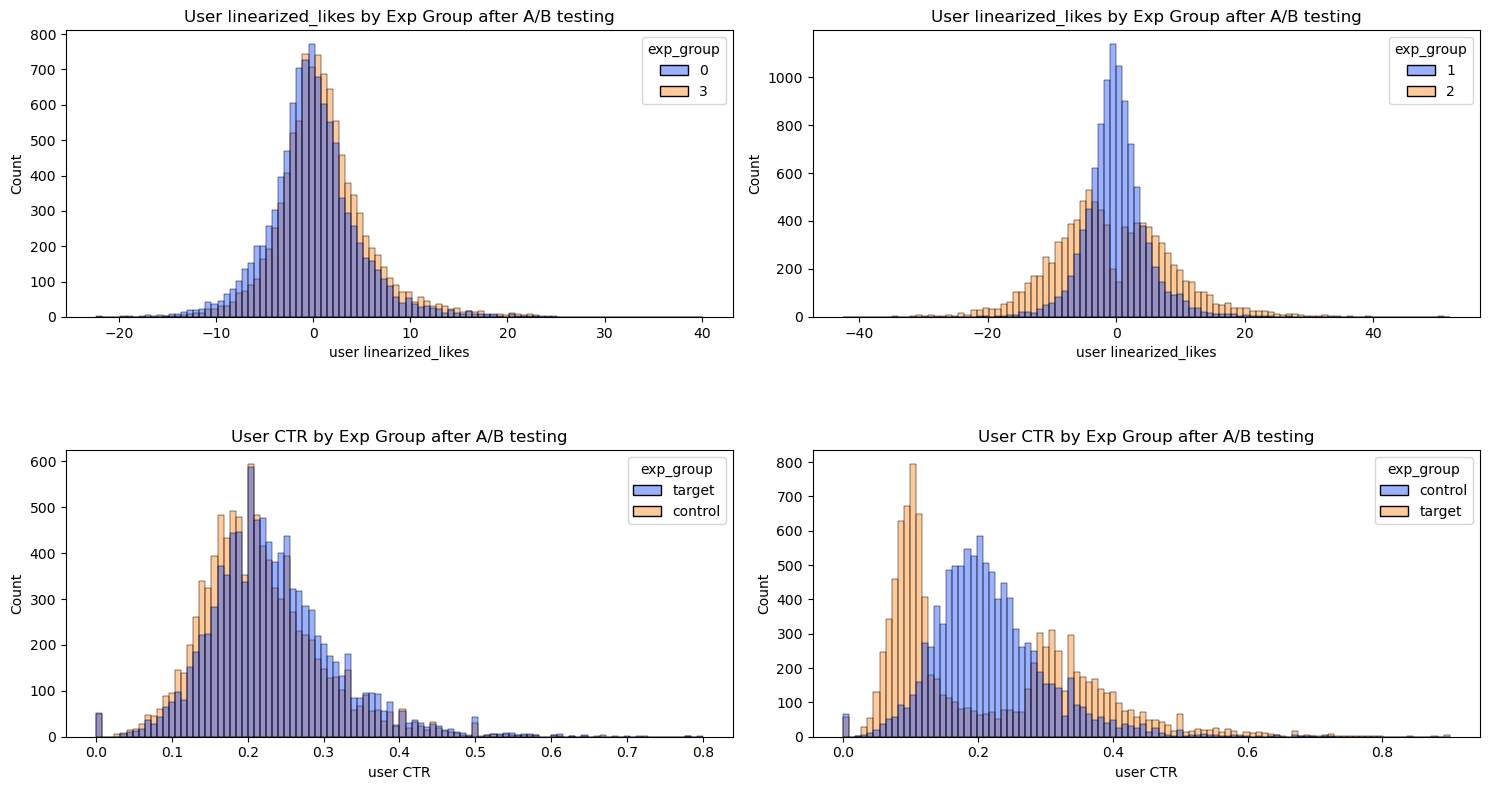

In [77]:
# make a canvas, set sizes
fig, axs = plt.subplots(2, 2, figsize=(15, 8))

to_plot.extend([hist_user_ctr_ab_3_4,
                hist_user_ctr_ab
               ]
              )

for plot, ax in zip(to_plot, axs.reshape(-1)):
    plot.plot(ax=ax)
    
plt.tight_layout(h_pad=5)

In [78]:
pvalues_df


,pair,pvalue
0,"(0, 3)",1.512081e-58
1,"(1, 2)",2.989818e-09


#### 3. Summary

1. Analyze the test between groups 0 and 3 using the metric of linearized likes. Is there any difference visible? Has 𝑝-value become smaller?

Yes, the difference is clear, p-value dropped from 6.3e-44 to 1.5e-58.


2. Analyze the test between groups 1 and 2 using the metric of linearized likes. Is there any difference visible? Has 𝑝-value become smaller?

Yes, the difference is clear, p-value dropped from 0.67 to 3e-9.